# SCRAPING DATA

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup
import re
import openai
import random
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np
import itertools

In [ ]:


url = input("Masukkan URL produk : ")

options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
options.add_argument("--disable-notifications")
options.add_argument("--disable-blink-features=AutomationControlled")
driver = webdriver.Chrome(options=options)
driver.get(url)

wait = WebDriverWait(driver, 15)
wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
nama_produk = soup.find("p", class_="css-akhxpb-unf-heading")
nama_produk = nama_produk.get_text(strip=True) if nama_produk else "Tidak ditemukan"

try:
    ulasan_tab = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'Ulasan')]")))
    ulasan_tab.click()
    time.sleep(3)
except:
    driver.quit()
    exit()

data, halaman, MAKS_HALAMAN = [], 1, 1000

while halaman <= MAKS_HALAMAN:
    try:
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "span[data-testid='lblItemUlasan']")))
    except:
        break

    soup = BeautifulSoup(driver.page_source, "html.parser")
    containers = soup.find_all("div", class_="css-1k41fl7")
    if not containers:
        break

    for c in containers:
        rating = len(c.find_all("svg", {"fill": "var(--YN300, #FFD45F)"}))
        tanggal_tag = c.find("p", class_="css-1rpz5os-unf-heading")
        tanggal = tanggal_tag.get_text(strip=True) if tanggal_tag else ""
        ulasan_tag = c.find("span", {"data-testid": "lblItemUlasan"})
        ulasan = ulasan_tag.get_text(strip=True) if ulasan_tag else ""
        if ulasan:
            data.append({"produk": nama_produk, "rating": rating, "tanggal": tanggal, "ulasan": ulasan})

    try:
        next_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[aria-label^='Laman berikutnya']")))
        driver.execute_script("arguments[0].click();", next_button)
        halaman += 1
        time.sleep(3)
    except:
        break

driver.quit()
pd.DataFrame(data).to_csv("xiaomi.csv", index=False, encoding="utf-8-sig")



# WORDCLOUD

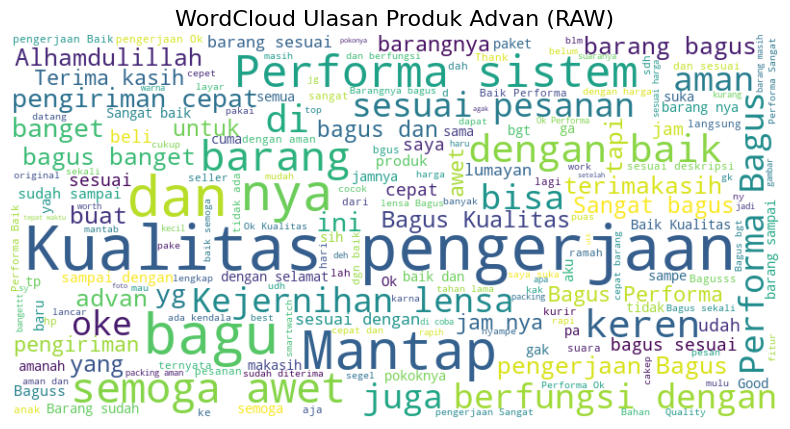

In [9]:

df = pd.read_csv("advan/advan.csv")

text_raw = " ".join(df["ulasan"].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text_raw)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Ulasan Produk Advan (RAW)", fontsize=16)
plt.show()

# Missing Value

In [33]:
print(df.isna().sum())

produk     0
rating     0
tanggal    0
ulasan     0
dtype: int64


In [34]:
invalid_rating = df[~df["rating"].astype(str).str.fullmatch(r"\d+(\.\d+)?")]
print(invalid_rating["rating"].unique())
print("Jumlah data tidak valid:", len(invalid_rating))

[]
Jumlah data tidak valid: 0


# Cleaning Dataset

In [10]:
def clean_text(text):
    if text is None or not isinstance(text, str):
        return text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s\U0001F600-\U0001F64F]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["hasil_cleaning"] = df["ulasan"].apply(clean_text)
df.to_csv("advan/advan_cleaned.csv", index=False)

# CASE FOLDING

In [11]:
def case_folding(text):
    if text is None or not isinstance(text, str):
        return text
    return text.lower()

df["casefolding"] = df["hasil_cleaning"].apply(case_folding)

df.to_csv("advan/advan_cf.csv", index=False)

# Tokenisasi

In [12]:
def tokenisasi(text):
    if not isinstance(text, str):
        return []
    return text.split()

df["tokenize"] = df["casefolding"].apply(tokenisasi)

df.to_csv("advan/advan_tokenisasi.csv", index=False)

# Normalisasi

In [13]:
kamus = pd.read_excel("kamuskatabaku.xlsx")
normalisasi_dict = dict(zip(kamus["tidak_baku"], kamus["kata_baku"]))

def normalisasi(tokens):
    if not isinstance(tokens, list):
        return []
    return [normalisasi_dict.get(t, t) for t in tokens]

df["normalisasi"] = df["tokenize"].apply(normalisasi)
df.to_csv("advan/advan_normalisasi.csv", index=False)


# STOPWORD REMOVAL

In [14]:
stopwords = ["dan", "ya", "di","dengan","sudah", "juga", "ini", "ke", "semoga", "barang", "yang"]

def stopword_removal(tokens):
    if not isinstance(tokens, list):
        return []
    return [t for t in tokens if t not in stopwords]

df["stopword"] = df["normalisasi"].apply(stopword_removal)
df.to_csv("advan/advan_stopword.csv", index=False)

# STEMMING

In [15]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(tokens):
    if not isinstance(tokens, list):
        return []
    result = []
    for t in tokens:
        stemmed = stemmer.stem(t)
        if stemmed is None or stemmed == "":
            result.append(t)       
        else:
            result.append(stemmed)
    return result

df["stemmed"] = df["stopword"].apply(stemming)
df.to_csv("advan/advan_stemmmed.csv", index=False)

# NEGASI MERGING

In [16]:
def gabung_tidak(tokens):
    if not isinstance(tokens, list):
        return []
    hasil = []
    skip = False
    for i, t in enumerate(tokens):
        if skip:
            skip = False
            continue
        if t == "tidak" and i + 1 < len(tokens):
            hasil.append(f"tidak{tokens[i + 1]}")
            skip = True
        else:
            hasil.append(t)
    return hasil

df["tokens_negasi"] = df["stemmed"].apply(gabung_tidak)
df.to_csv("advan/advan_tokens_negasi.csv", index=False)

# CLEAN TEXT

In [17]:
def gabung_tokens_negasi(tokens):
    if isinstance(tokens, str):
        try:
            tokens = ast.literal_eval(tokens)
        except:
            return ""
    if isinstance(tokens, list):
        return " ".join(tokens)
    return ""

df["text_clean"] = df["tokens_negasi"].apply(gabung_tokens_negasi)
df.to_csv("advan/advan_preprocessed.csv", index=False, encoding="utf-8-sig")

# WordCloud Preprocessed

# LABELING

In [ ]:
openai.api_key = "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"
openai.api_base = "https://openrouter.ai/api/v1"

df = pd.read_csv("advan/advan_preprocessed.csv")

def gpt_sentiment(text, max_retries=3):
    if not isinstance(text, str) or text.strip() == "":
        return "Netral", 0.0

    prompt = f"""
    Kamu adalah model NLP. Klasifikasikan sentimen teks berikut menjadi: Positif, Negatif, atau Netral.
    Berikan juga tingkat keyakinan (confidence) dalam rentang 0–1.

    Balas dalam format JSON seperti ini:
    {{
        "sentiment": "Positif",
        "confidence": 0.92
    }}

    Teks:
    "{text}"
    """

    for _ in range(max_retries):
        try:
            res = openai.ChatCompletion.create(
                model="openai/gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )

            reply = res.choices[0].message["content"].strip()

            # Coba parsing JSON
            try:
                data = json.loads(reply)
                sentiment = data.get("sentiment", "Netral")
                confidence = float(data.get("confidence", 0.0))
                return sentiment, confidence
            except:
                print("Format JSON tidak valid, output:", reply)
                return "Netral", 0.0

        except Exception as e:
            print(f"Error: {e}")
            time.sleep(2 + random.random() * 3)

    return "Netral", 0.0


results_sentiment = []
results_conf = []

for i, text in enumerate(df["ulasan"]):
    sentiment, conf = gpt_sentiment(text)
    results_sentiment.append(sentiment)
    results_conf.append(conf)

    if i % 20 == 0:
        df["Sentiment"] = results_sentiment + [""] * (len(df) - len(results_sentiment))
        df["Confidence"] = results_conf + [""] * (len(df) - len(results_conf))
        df.to_csv("advan/hasil_label_advan_partial.csv", index=False, encoding="utf-8-sig")
        print(f"Progress saved at row {i}")

df["Sentiment"] = results_sentiment
df["Confidence"] = results_conf
df.to_csv("advan/advan_labeled_by_nlp_cf.csv", index=False, encoding="utf-8-sig")

print("Hasil labeling disimpan ke advan/advan_labeled_by_nlp_cf.csv")


Progress saved at row 0
Progress saved at row 20
Progress saved at row 40
Progress saved at row 60
Progress saved at row 80
Progress saved at row 100
Progress saved at row 120
Progress saved at row 140
Progress saved at row 160
Progress saved at row 180
Progress saved at row 200
Progress saved at row 220
Progress saved at row 240
Progress saved at row 260
Progress saved at row 280
Progress saved at row 300
Progress saved at row 320
Progress saved at row 340
Progress saved at row 360
Progress saved at row 380
Progress saved at row 400
Progress saved at row 420
Progress saved at row 440
Progress saved at row 460
Progress saved at row 480
Progress saved at row 500
Progress saved at row 520
Progress saved at row 540
Progress saved at row 560
Progress saved at row 580
Progress saved at row 600
Progress saved at row 620
Progress saved at row 640
Progress saved at row 660
Progress saved at row 680
Progress saved at row 700
Progress saved at row 720
Progress saved at row 740
Progress saved at 

# Jumlah Label by NLP

In [ ]:
df = pd.read_csv("advan/advan_labeled.csv")

print(df["Sentiment"].value_counts())

Sentiment
Positif     2813
Netral       320
Negatif      197
Campuran       1
Name: count, dtype: int64


# Ngambil Kolom Sentimen Dari CSV ke CSV lain

In [19]:

source_df = pd.read_csv("advan/advan_labeled_by_nlp_cf.csv") 
target_df = pd.read_csv("advan/advan_preprocessed.csv")

target_df["Sentiment"] = source_df["Sentiment"]
target_df["Confidence"] = source_df["Confidence"]

target_df.to_csv("advan/advan_preprocessed_with_sentiment.csv", index=False)

print("Kolom 'Sentiment' dan 'Confidence' berhasil disalin ke CSV target!")

Kolom 'Sentiment' dan 'Confidence' berhasil disalin ke CSV target!


# Separate Low Confidence

In [22]:
df = pd.read_csv("advan/advan_preprocessed_with_sentiment.csv")

low_confidence_df = df[df["Confidence"] <= 0.8]

low_confidence_df.to_csv("advan/advan_low_cf.csv", index=False)

print(f"Berhasil memisahkan {len(low_confidence_df)} data dengan confidence rendah ke 'advan/advan_low_cf.csv'")

Berhasil memisahkan 288 data dengan confidence rendah ke 'advan/advan_low_cf.csv'


# Replace The Processed Data

In [20]:
df_main = pd.read_csv("advan/advan_preprocessed_with_sentiment.csv")
df_revised = pd.read_csv("advan/advan_low_cf.csv")

df_revised_unique = df_revised.drop_duplicates(subset=['ulasan'], keep='last')

sentiment_map = pd.Series(df_revised_unique.Sentiment.values, index=df_revised_unique.ulasan).to_dict()

df_main['Sentiment'] = df_main['ulasan'].map(sentiment_map).fillna(df_main['Sentiment'])

df_main.to_csv("advan/advan_preprocessed_fix.csv", index=False)

print("Dataset berhasil diperbarui dan disimpan ke 'advan/advan_preprocessed_fix.csv'")

Dataset berhasil diperbarui dan disimpan ke 'advan/advan_preprocessed_fix.csv'


# Cek Jumlah Record

In [21]:
df = pd.read_csv("advan/advan_preprocessed_fix.csv")

print(f"Jumlah record: {len(df)}")


print(f"Dimensi dataset: {df.shape}")
print(f"Jumlah record saja: {df.shape[0]}")

Jumlah record: 3331
Dimensi dataset: (3331, 14)
Jumlah record saja: 3331


# Modeling

In [30]:
df = pd.read_csv("advan/advan_preprocessed_fix.csv").fillna('')
X = df["text_clean"].astype(str)
y = df["Sentiment"]

split_scenarios = {
    "70:30": 0.3,
    "80:20": 0.2,
    "90:10": 0.1
}

global_best_score = 0
global_best_model = None
global_best_vectorizer = None
global_best_info = ""

for ratio_name, test_size in split_scenarios.items():
    print(f"\n{'='*20} PENGUJIAN SPLIT RATIO {ratio_name} {'='*20}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2), sublinear_tf=True, token_pattern=r'(?u)\b\w\w+\b')
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "Naive Bayes": MultinomialNB(),
        "SVM": LinearSVC(class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    }
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        
        acc = accuracy_score(y_test, y_pred)
        
        results.append([
            name,
            acc,
            precision_score(y_test, y_pred, average='weighted', zero_division=0),
            recall_score(y_test, y_pred, average='weighted', zero_division=0),
            f1_score(y_test, y_pred, average='weighted', zero_division=0)
        ])
        
        if acc > global_best_score:
            global_best_score = acc
            global_best_model = model
            global_best_vectorizer = vectorizer
            global_best_info = f"{name} (Ratio {ratio_name})"

    comparison = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
    print(comparison)

print(f"\n{'='*50}")
print(f"KESIMPULAN AKHIR: Model Terbaik adalah {global_best_info} dengan Accuracy: {global_best_score:.4f}")
print(f"{'='*50}")

model_filename = f"{global_best_info.split(' (')[0].replace(' ', '_').lower()}_best_model.pkl"
joblib.dump(global_best_model, model_filename)
joblib.dump(global_best_vectorizer, "tfidf_vectorizer.pkl")

print(f"Model terbaik berhasil disimpan sebagai '{model_filename}' dan vectorizer disimpan.")


==================== PENGUJIAN SPLIT RATIO 70:30 ====================
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression     0.888   0.900941   0.888  0.893248
1          Naive Bayes     0.857   0.734449   0.857  0.791006
2                  SVM     0.903   0.898899   0.903  0.897987
3        Random Forest     0.880   0.864393   0.880  0.858438

==================== PENGUJIAN SPLIT RATIO 80:20 ====================
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.892054   0.904620  0.892054  0.897369
1          Naive Bayes  0.857571   0.735428  0.857571  0.791817
2                  SVM  0.908546   0.901189  0.908546  0.903114
3        Random Forest  0.871064   0.848936  0.871064  0.851700

==================== PENGUJIAN SPLIT RATIO 90:10 ====================
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.898204   0.905560  0.898204  0.901403
1          Naive Bayes  0.856

In [73]:
df = pd.read_csv("xiaomi/xiaomi.csv")
display(df)

,produk,rating,tanggal,ulasan
0,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,Hari ini,Barang sudah sampai sesuai dengan pesanan. Ter...
1,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,Hari ini,"berfungsi normal, semoga awet"
2,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,Hari ini,"barang bagus ,seller amanah"
3,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,Hari ini,barang masih segel garansi resmi Indonesia
4,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,Hari ini,barang sesuai deskripsi
...,...,...,...,...
1821,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",4,2 minggu lalu,kurang sim card ejector
1822,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,2 minggu lalu,mantaps kak.... barang original segel no tepack
1823,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,2 minggu lalu,barang original bergaransi resmi
1824,"Xiaomi Smart Band 9 Pro | Bezel Tipis 1,74 | 1...",5,2 minggu lalu,barang ori.... no repack


# Pakai Model Untuk Klasifikasi Sentiment Produk Lain

In [95]:
df = pd.read_csv("xiaomi/xiaomi_preprocessed.csv")

model = joblib.load("logistic_regression_best_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

X_vec = vectorizer.transform(df["text_clean"].astype(str))

df["Sentiment"] = model.predict(X_vec)

df.to_csv("xiaomi/xiaomi_labeled_by_model.csv", index=False)


# Predict Pakai XGBoost 

In [ ]:
df = pd.read_csv("xiaomi/xiaomi_preprocessed.csv")
model = joblib.load("xgboost_best_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

X_vec = vectorizer.transform(df["text_clean"].astype(str))
pred = model.predict(X_vec)

le = LabelEncoder()
le.fit(["Negatif", "Netral", "Positif"])  
df["Sentiment"] = le.inverse_transform(pred)

df.to_csv("xiaomi/xiaomi_labeled_by_model.csv", index=False)

# Akurasi Ketika Model Memprediksi Dataset Lain

In [40]:
df_true = pd.read_csv("xiaomi/xiaomi_labeled_by_nlp.csv").sort_values("ulasan").reset_index(drop=True)
df_pred = pd.read_csv("xiaomi/xiaomi_labeled_by_model.csv").sort_values("ulasan").reset_index(drop=True)

y_true = df_true["Sentiment"].astype(str).str.lower()
y_pred = df_pred["Sentiment"].astype(str).str.lower()


print(f"Akurasi: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Akurasi: 0.8549

Classification Report:
              precision    recall  f1-score   support

     negatif     0.5849    0.5536    0.5688       112
      netral     0.3883    0.4848    0.4313       165
     positif     0.9373    0.9161    0.9265      1549

    accuracy                         0.8549      1826
   macro avg     0.6368    0.6515    0.6422      1826
weighted avg     0.8660    0.8549    0.8598      1826



# Visualisasi Confusion Matrix

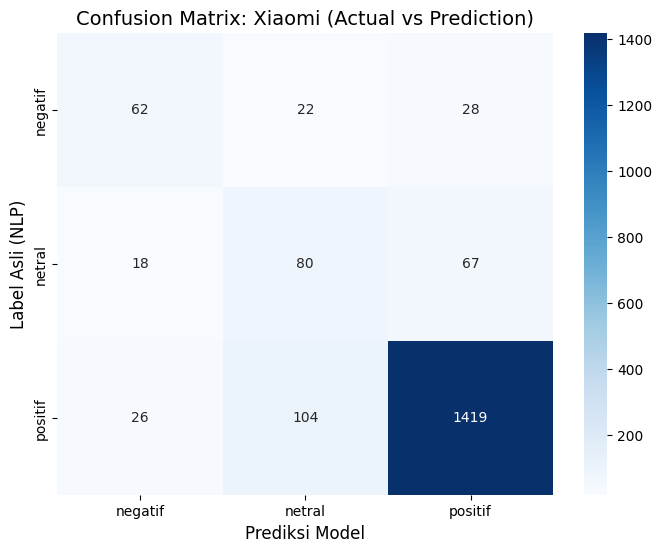

In [41]:
cm = confusion_matrix(y_true, y_pred)
labels = sorted(y_true.unique())  # Mendapatkan label unik secara urut (negatif, netral, positif)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Xiaomi (Actual vs Prediction)', fontsize=14)
plt.ylabel('Label Asli (NLP)', fontsize=12)
plt.xlabel('Prediksi Model', fontsize=12)
plt.savefig("image/xiaomi/confusion_matrix.png", bbox_inches='tight')
plt.show()

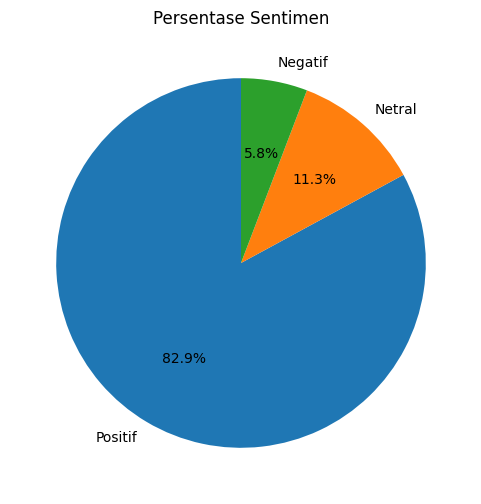

In [ ]:
df = pd.read_csv("xiaomi/xiaomi_labeled_by_model.csv")

plt.figure(figsize=(6,6))
df["Sentiment"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Persentase Sentimen')

plt.savefig("image/xiaomi/persentase_sentimen.png", bbox_inches='tight')
plt.show()

# WordCloud Sentimen Negatif

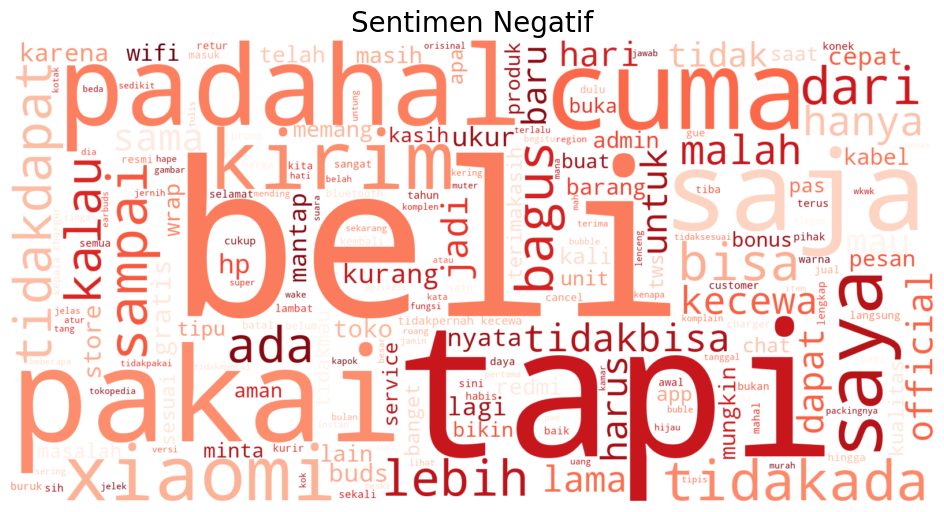

In [ ]:
df = pd.read_csv("xiaomi/xiaomi_labeled_by_model.csv")

df_neg = df[df["Sentiment"] == "Negatif"]
text_neg = " ".join(df_neg["text_clean"].astype(str))

wordcloud_neg = WordCloud(width=1600, height=800, background_color='white', colormap='Reds').generate(text_neg)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Negatif", fontsize=20)
plt.savefig("image/xiaomi/wordcloud_negatif.png", bbox_inches='tight')
plt.show()

# WordCloud Sentimen Positif

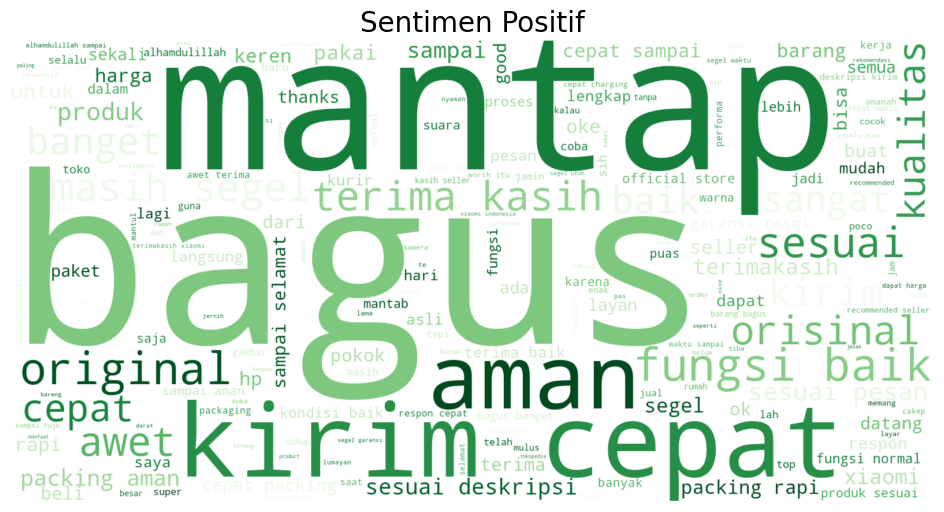

In [ ]:
df = pd.read_csv("xiaomi/xiaomi_labeled_by_model.csv")

df_pos = df[df["Sentiment"] == "Positif"]
text_pos = " ".join(df_pos["text_clean"].astype(str))

wordcloud_pos = WordCloud(width=1600, height=800, background_color='white', colormap='Greens').generate(text_pos)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Positif", fontsize=20)
plt.savefig("image/xiaomi/wordcloud_positif.png", bbox_inches='tight')
plt.show()

# WordCloud Sentimen Netral

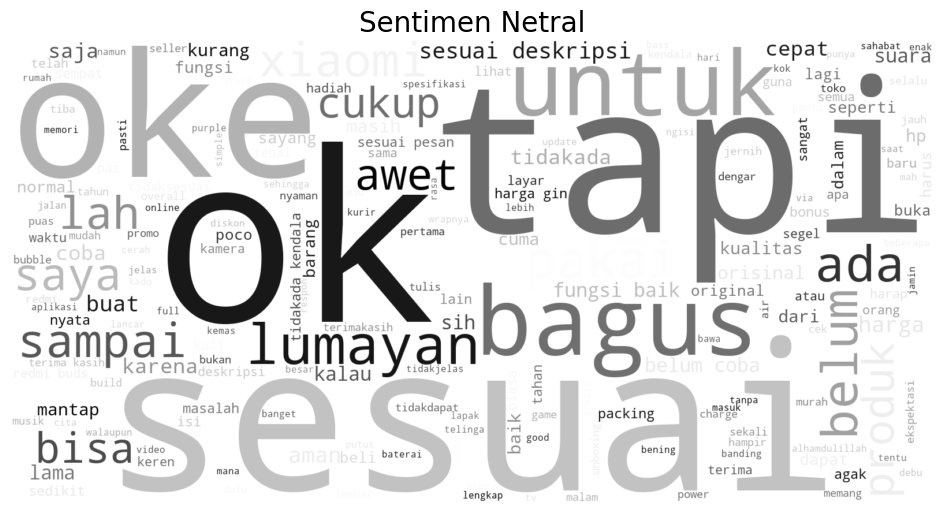

In [ ]:
df = pd.read_csv("xiaomi/xiaomi_labeled_by_model.csv")

df_neu = df[df["Sentiment"] == "Netral"]
text_neu = " ".join(df_neu["text_clean"].astype(str))

wordcloud_neu = WordCloud(width=1600, height=800, background_color='white', colormap='Greys').generate(text_neu)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Netral", fontsize=20)
plt.savefig("image/xiaomi/wordcloud_netral.png", bbox_inches='tight')
plt.show()

# Sentiment Advan

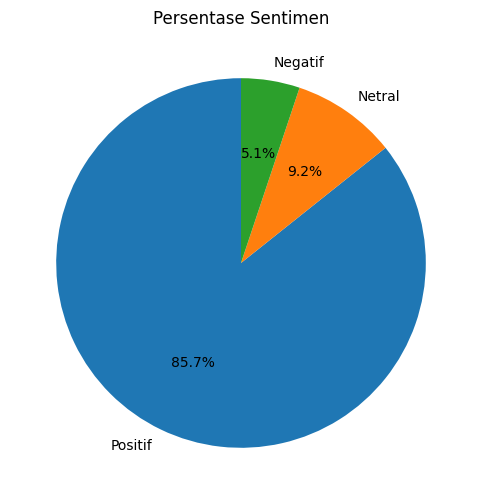

In [ ]:
df = pd.read_csv("advan/advan_preprocessed_fix.csv")

plt.figure(figsize=(6,6))
df["Sentiment"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Persentase Sentimen')

plt.savefig("image/advan/persentase_sentimen.png", bbox_inches='tight')
plt.show()

# Sentiment Advan Netral

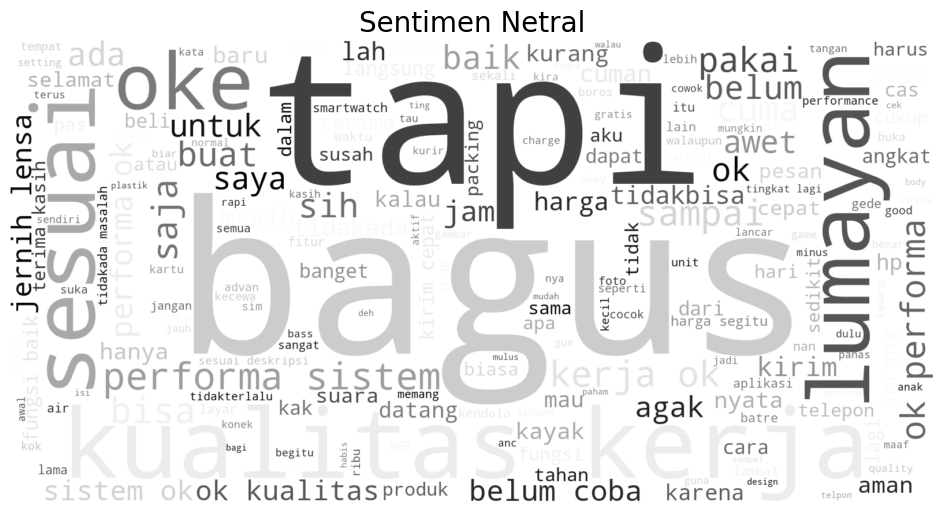

In [38]:
df_neu = df[df["Sentiment"] == "Netral"]
text_neu = " ".join(df_neu["text_clean"].astype(str))

wordcloud_neu = WordCloud(width=1600, height=800, background_color='white', colormap='Greys').generate(text_neu)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Netral", fontsize=20)
plt.savefig("image/advan/wordcloud_netral.png", bbox_inches='tight')
plt.show()

# Sentiment Advan Positif

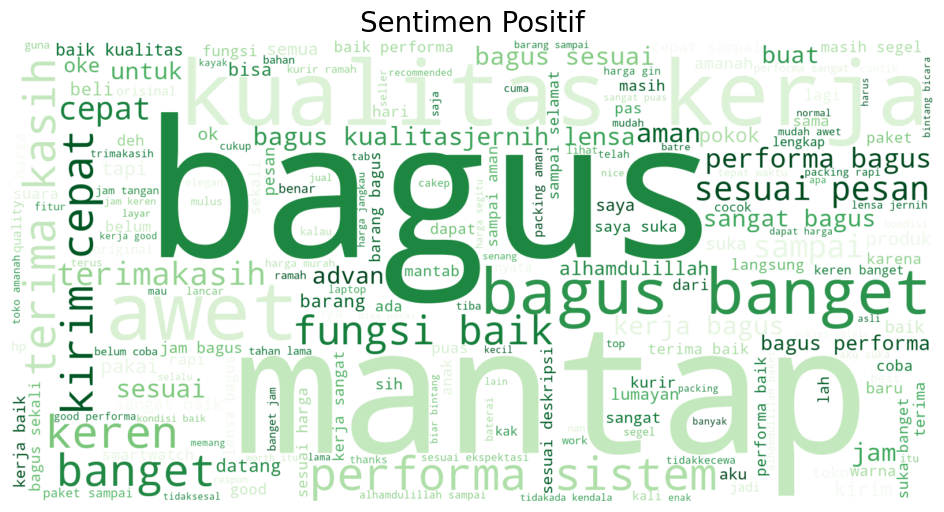

In [42]:
df_pos = df[df["Sentiment"] == "Positif"]
text_pos = " ".join(df_pos["text_clean"].astype(str))

wordcloud_pos = WordCloud(width=1600, height=800, background_color='white', colormap='Greens').generate(text_pos)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Positif", fontsize=20)
plt.savefig("image/advan/wordcloud_positif.png", bbox_inches='tight')
plt.show()

# Sentiment Advan Negatif

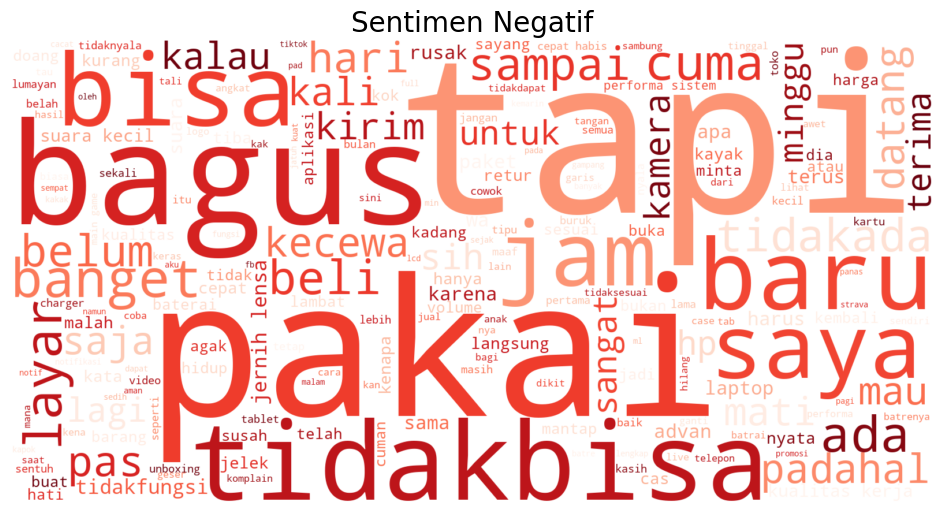

In [43]:
df_neg = df[df["Sentiment"] == "Negatif"]
text_neg = " ".join(df_neg["text_clean"].astype(str))

wordcloud_neg = WordCloud(width=1600, height=800, background_color='white', colormap='Reds').generate(text_neg)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Sentimen Negatif", fontsize=20)
plt.savefig("image/advan/wordcloud_negatif.png", bbox_inches='tight')
plt.show()

# TOPIC MODELING

# Mencari Konfigurasi LDA Terbaik

In [13]:
df = pd.read_csv("advan/advan_preprocessed_fix.csv").fillna('')
data_neg = df[df['Sentiment'] == 'Negatif']['text_clean'].astype(str).tolist()


tokens = [text.split() for text in data_neg]
dictionary_gensim = Dictionary(tokens)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(data_neg)
feature_names = tf_vectorizer.get_feature_names_out()

search_params = {
    'n_components': [3, 4, 5, 6],
    'doc_topic_prior': [0.1, 0.5, 0.9], 
    'topic_word_prior': [0.1, 0.5, 0.9] 
}

param_combinations = list(itertools.product(
    search_params['n_components'],
    search_params['doc_topic_prior'],
    search_params['topic_word_prior']
))

results = []
print(f"   Memproses {len(param_combinations)} kombinasi parameter...")

for n_topics, alpha, eta in param_combinations:

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        doc_topic_prior=alpha,
        topic_word_prior=eta,
        max_iter=10,
        learning_method='batch',
        random_state=42,
        n_jobs=-1
    )
    lda.fit(tf)

    top_words_per_topic = [
        [feature_names[i] for i in topic.argsort()[:-11:-1]] 
        for topic in lda.components_
    ]
    
    coherence_score = CoherenceModel(
        topics=top_words_per_topic,
        texts=tokens,
        dictionary=dictionary_gensim,
        coherence='c_v'
    ).get_coherence()


    dominant_topic = np.argmax(lda.transform(tf), axis=1)
    sil_score = silhouette_score(tf, dominant_topic) if len(set(dominant_topic)) > 1 else -1

    results.append({
        'Num of topics': n_topics,
        'alpha': alpha,
        'eta': eta,
        'Silhouette Score': sil_score,
        'Coherence Score': coherence_score
    })

df_tuning = pd.DataFrame(results).sort_values(by='Coherence Score', ascending=False).reset_index(drop=True)

best = df_tuning.iloc[0]
best_n_topics = int(best['Num of topics'])
best_alpha = best['alpha']
best_eta = best['eta']

df_results = pd.DataFrame(results).sort_values(by='Coherence Score', ascending=False).reset_index(drop=True)

# Konfigurasi agar tabel terlihat penuh di console
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None) # Tampilkan semua baris

print("\n=== TABEL HASIL HYPERPARAMETER TUNING (SEMUA PERCOBAAN) ===")
print(df_results)


   Memproses 36 kombinasi parameter...

=== TABEL HASIL HYPERPARAMETER TUNING (SEMUA PERCOBAAN) ===
    Num of topics  alpha  eta  Silhouette Score  Coherence Score
0               5    0.1  0.9         -0.058984         0.425038
1               6    0.9  0.9         -0.029194         0.416528
2               5    0.1  0.1         -0.059521         0.411522
3               4    0.9  0.9          0.000389         0.400857
4               3    0.9  0.9          0.006107         0.386328
5               6    0.9  0.5         -0.003086         0.385330
6               5    0.9  0.5         -0.006361         0.377740
7               5    0.9  0.9         -0.003821         0.373898
8               5    0.1  0.5         -0.059778         0.370083
9               6    0.5  0.9         -0.034781         0.363196
10              5    0.5  0.1         -0.025640         0.358514
11              3    0.5  0.9         -0.006098         0.357965
12              4    0.5  0.5         -0.010275        

# Implementasi LDA dengan Hyperparameter Tuning Terbaik


=== INTERPRETASI TOPIK TERBAIK ===
Topik 1: bisa, sampai, tidakada, mati, belum, pakai, saya, kalau, beli, ada
Topik 2: tapi, jam, layar, suara, pakai, baru, ada, padahal, banget, kecil
Topik 3: pakai, tidakbisa, tapi, bagus, sih, datang, rusak, beli, belum, cuma
Topik 4: tidakbisa, tapi, cuma, hp, datang, retur, sama, laptop, layar, saja
Topik 5: bagus, kali, kualitas, jernih, kerja, banget, performa, lensa, tapi, kecewa


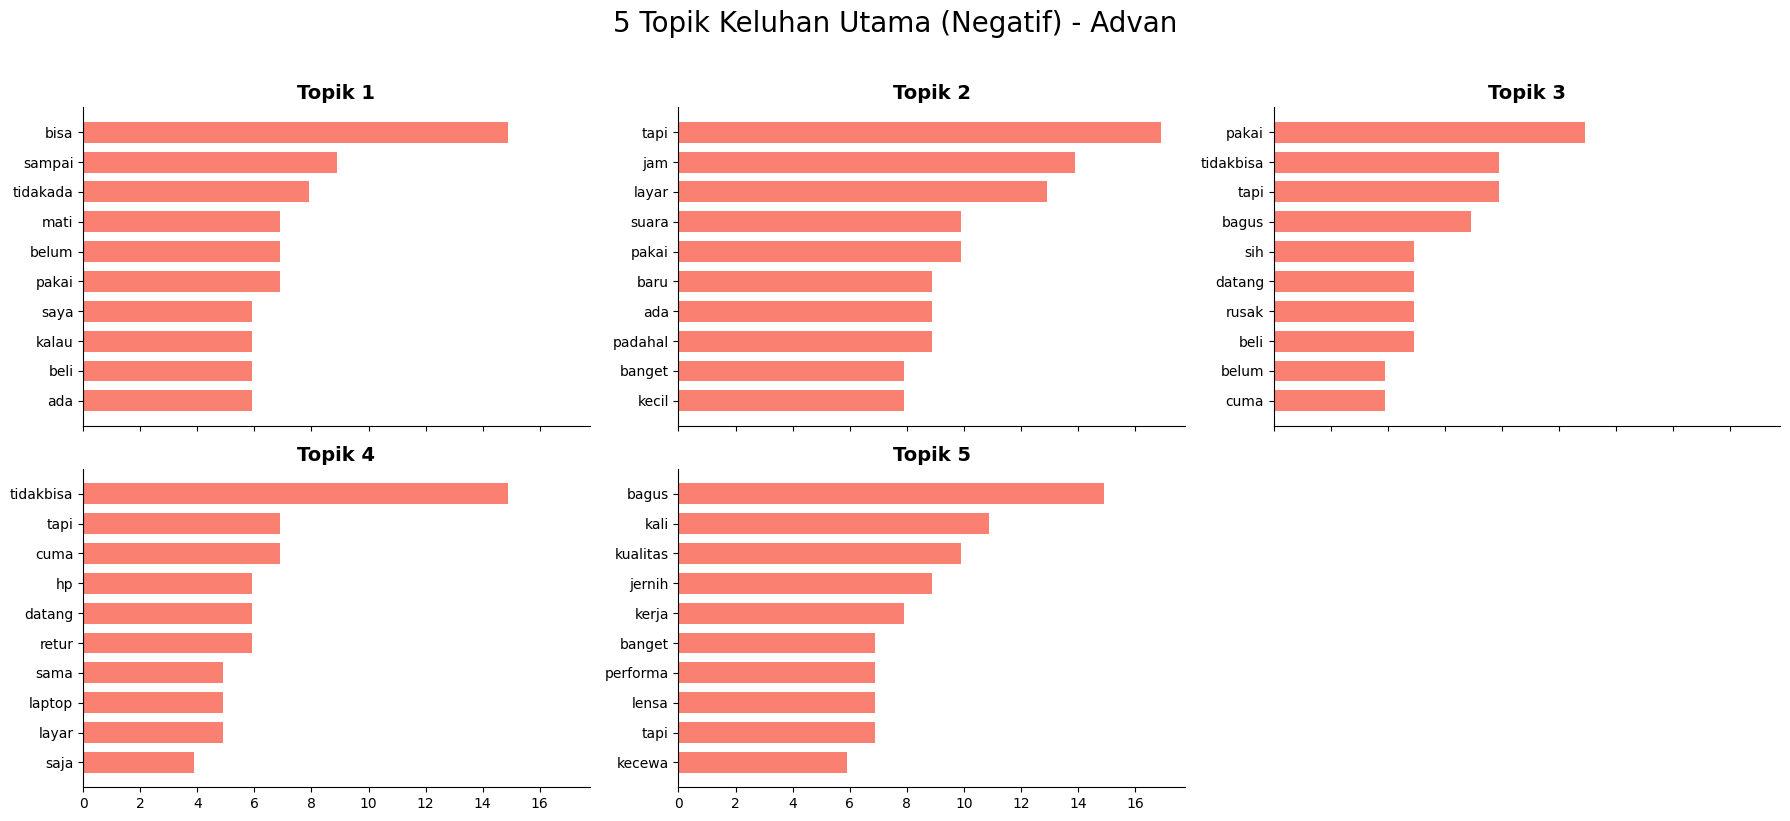

In [14]:
lda_final = LatentDirichletAllocation(
    n_components=best_n_topics,
    doc_topic_prior=best_alpha,
    topic_word_prior=best_eta,
    max_iter=20,
    learning_method='batch',
    random_state=42,
    n_jobs=-1
)
lda_final.fit(tf)

def plot_top_words(model, feature_names, n_top_words, title):
    rows = (model.n_components + 2) // 3  
    fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='salmon')
        ax.set_title(f'Topik {topic_idx + 1}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        ax.invert_yaxis()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

  
    for i in range(topic_idx + 1, len(axes)):
        axes[i].axis('off')

    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# Print & Plot Hasil
print("\n=== INTERPRETASI TOPIK TERBAIK ===")
for topic_idx, topic in enumerate(lda_final.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topik {topic_idx + 1}: {', '.join(top_features)}")

plot_top_words(lda_final, feature_names, 10, f'{best_n_topics} Topik Keluhan Utama (Negatif) - Advan')